# Fit MRP parameters to mock data that has arbitrary measurement uncertainty with Stan

In this example, we will create mock data sets that mimic what we might expect to measure from a galaxy survey such as GAMA, in which each halo measured has an associated uncertainty. We will then test how well each is fit. THis will show how to use ``mrpy`` to fit haloes with measurement uncertainties.

**The figures produced in this example appear as figures 8,9 and 10 of MRP**

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mrpy.fit_perobj import fit_perobj_stan,_compile_model
from mrpy.stats import TGGD, TGGDlog
import pickle
from scipy.stats import gaussian_kde

## Create Sample Data

In [7]:
# First define the basic characteristics of our data set.
log_mmin = 12
alpha = -1.85
beta = 0.72
logHs = 14.2
N = 15000
sd_base = [0.2,0.3,0.5,0.8]

In [8]:
# Now create a single set of intrinsic masses used throughout.
np.random.seed(1234)
log_m_intrinsic = np.log10(TGGD(10**logHs,alpha,beta,10**log_mmin).rvs(N))

In [9]:
# Create four "measured" versions, each with different amount of uncertainty.
np.random.seed(4321)
sd_dex = []
log_m_meas = []
for i,sd in enumerate(sd_base):
    sd_dex.append(np.random.normal(sd,sd/6,size=N))
    log_m_meas.append(np.random.normal(log_m_intrinsic,sd_dex[i]))

## Perform MCMC

Define some characteristics of the MCMC run.

In [10]:
warmup = 300
iters = 1000
chains = 4

In this case, we'll start close to the correct solution.

In [11]:
init = [{"logHs":logHs,"alpha":alpha,"beta":beta,"log_mtrue":log_m_intrinsic,"log_mmin":log_mmin}]*chains

The following performs the mcmc on all of our samples with full per-object uncertainty

In [12]:
fit_err = []
model = _compile_model(True)
for i,(logm, sd) in enumerate(zip(log_m_meas,sd_dex)):
    
    if i==1 or i==2:
        continue
        
    # For the very uncertain case, increase the warmup and iters
    mult=1
    if i==3:
        mult=2
    
    # Run the sampling
    fit_err += [fit_perobj_stan(10**logm,sd,warmup=mult*warmup,iter=mult*iters,hs_bounds=(logHs-2,logHs+2),
                        alpha_bounds=(-1.99,-1.5),beta_bounds=(beta-0.2,beta+0.2),
                        mmin_bounds=(11,13),n_jobs=chains,chains=chains,init=init,
                        pars=['logHs',"alpha","beta",'log_mmin'],model=model)]
    
    # Pickle the result for later use
    with open("stan_model/uncertain_fit_%s.pickle"%i,'w') as f:
        pickle.dump(fit_err[i],f)
        
    print "Done %s."%(i+1)

/home/steven/anaconda2/lib/python2.7/pickle.py:306: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reduce(self.proto)


Done 1.


IndexError: list index out of range

Alternatively, we could rather try using no uncertainties, but discarding data below the "perceived" truncation mass.

In [13]:
fit_noerr = []
for i,(logm,mtrunc) in enumerate(zip(log_m_meas,[12.4,12.7,13.0,13.4])):
    fit_noerr += [fit_perobj_stan(10**logm[logm>mtrunc],warmup=warmup,iter=iters,hs_bounds=(logHs-2,logHs+2),
                                 alpha_bounds=(-1.99,-1.5),beta_bounds=(beta-0.2,beta+0.2),
                                 n_jobs=chains,chains=chains)]
    with open("stan_model/certain_fit_%s.pickle"%i,'w') as f:
        pickle.dump(fit_noerr[i],f)

Using cached StanModel
Using cached StanModel
Using cached StanModel


We also need a run directly on the intrinsic masses.

In [111]:
fit_intrinsic = fit_perobj_stan(10**log_m_intrinsic,warmup=warmup,iter=iters,hs_bounds=(logHs-2,logHs+2),
                             alpha_bounds=(-1.99,-1.5),beta_bounds=(beta-0.2,beta+0.2),
                             n_jobs=chains,chains=chains)

with open("stan_model/intrinsic_fit_%s.pickle"%i,'w') as f:
    pickle.dump(fit_intrinsic,f)

Using cached StanModel


## Some Plots

### Density Plot

To check the intrinsic distribution versus the final estimated distribution, we use a density plot. First we define a simple function to extract the mean parameters from a run:

In [113]:
def get_posterior_mean(sf):
    x = sf.get_posterior_mean()
    logHs = np.mean(x[0,:])
    alpha = np.mean(x[1,:])
    beta = np.mean(x[2,:])
    post_mmin = np.mean(x[3,:])
    m = np.mean(x[4:-1,:],axis=-1)
    return logHs,alpha,beta,post_mmin,m

In [227]:
# Get the posterior parameters for the A=0.8 case
def plot_density(sf,plot_est_m=False):
    
    # Get posterior means
    post_hs, post_alpha,post_beta, post_mmin,post_m = get_posterior_mean(sf)

    # Create x co-ords for plot
    x = np.linspace(log_m_intrinsic.min(),log_m_intrinsic.max(),50)

    # Set figure size
    fig, ax = plt.subplots(figsize=(6,3.75))
    
    # Plot different densities
    ax.plot(x,gaussian_kde(log_m_intrinsic)(x), label="Intrinsic",lw=2) # Intrinsic masses
    ax.plot(x,gaussian_kde(sf.data['log_m_meas'])(x) , label="Uncertain",lw=2)  # "Measured" masses with 0.8 dex base uncertainty
    ax.plot(x,TGGDlog(logHs,alpha,beta,log_mmin).pdf(x), label="Intrinsic PDF",lw=2)
    ax.plot(x,TGGDlog(post_hs,post_alpha,post_beta,post_mmin).pdf(x), label="Estimated PDF",lw=2)
    if plot_est_m:
        ax.plot(x,gaussian_kde(post_m)(x), label="Estimated",lw=2)

    # Annotate mean uncertainty
    ax.text(0.8,0.9,r"S = %.1f"%np.mean(sf.data['sd_dex']),transform=ax.transAxes,
           fontdict={"fontsize":16})
    
    # Axis styling
    ax.set_yscale('log')
    ax.legend(loc=3)
    ax.set_xlabel(r"$\log_{10} m$,  [$h^{-1}M_\odot$]",fontsize=15)
    ax.set_ylabel("Normalised HMF",fontsize=15)

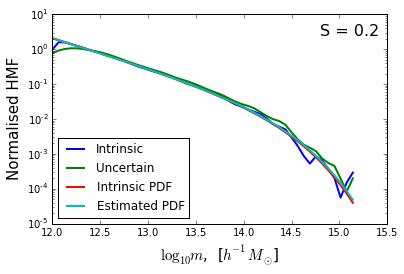

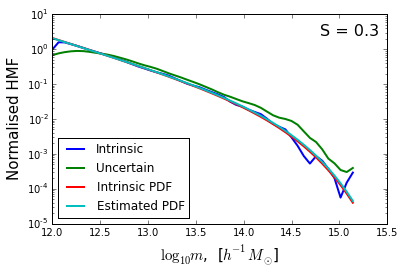

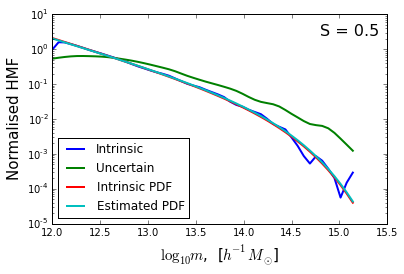

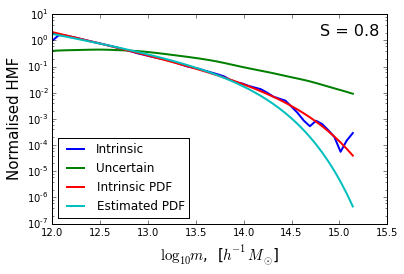

In [228]:
plot_density(fit_err[0])
plt.show()
plot_density(fit_err[1])
plt.show()
plot_density(fit_err[2])
plt.show()
plot_density(fit_err[-1])

# Save last one for the paper!
plt.savefig("../../../mrpArticle/figures/heirarchical_density.pdf")

### Corner/Pairs Plots

In [89]:
from corner import corner

In [104]:
def plot_corner(sf):
    chain = sf.extract(('logHs',"alpha","beta",'log_mmin'))
    fig = corner(np.array([v for k,v in chain.items()]).T,bins=30,
                 labels=[r"$\log \mathcal{H}_\star$",r"$\alpha$",r"$\beta$",r"$\log m_{\rm min}$"],
                 label_kwargs={"fontsize":22},
                 truths = [logHs,alpha,beta,log_mmin],
                 smooth=0.6)

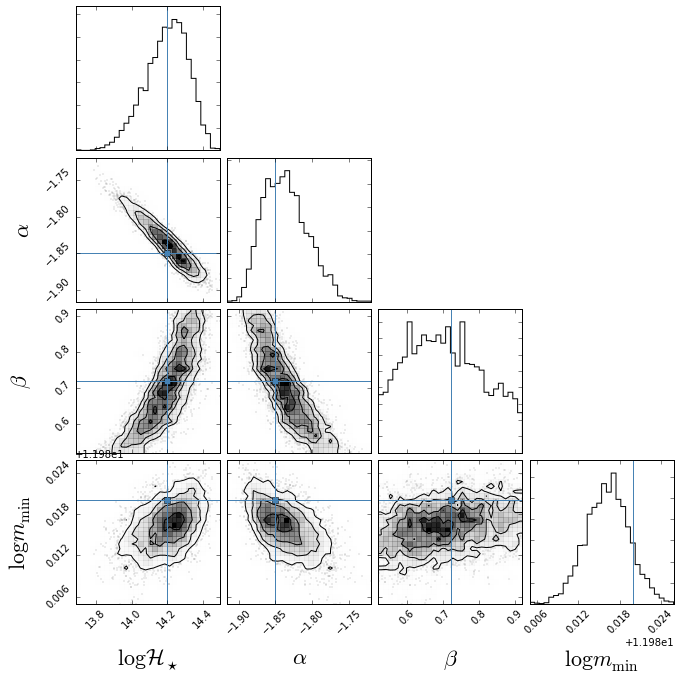

In [106]:
# Corner plot for A=0.2
plot_corner(fit_err[0])

# Save for the paper!
plt.savefig("../../../mrpArticle/figures/heirarchical_corner.pdf")

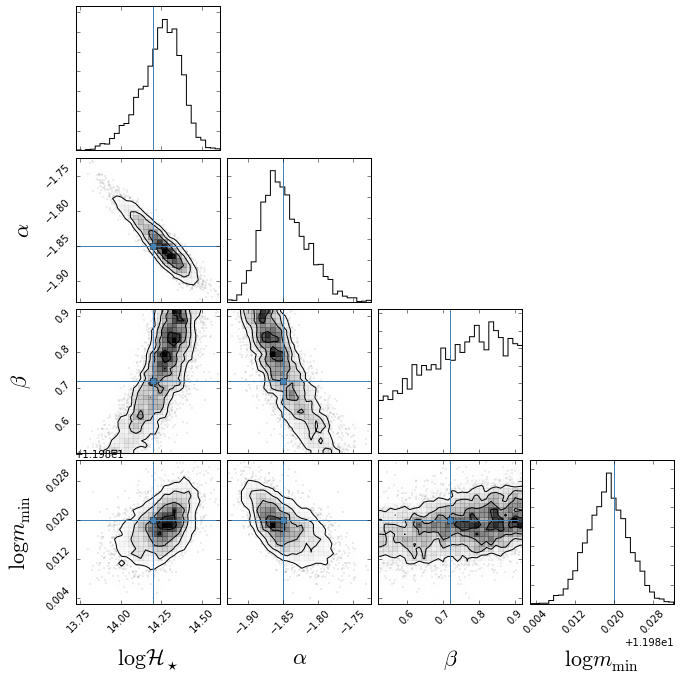

In [107]:
plot_corner(fit_err[1])

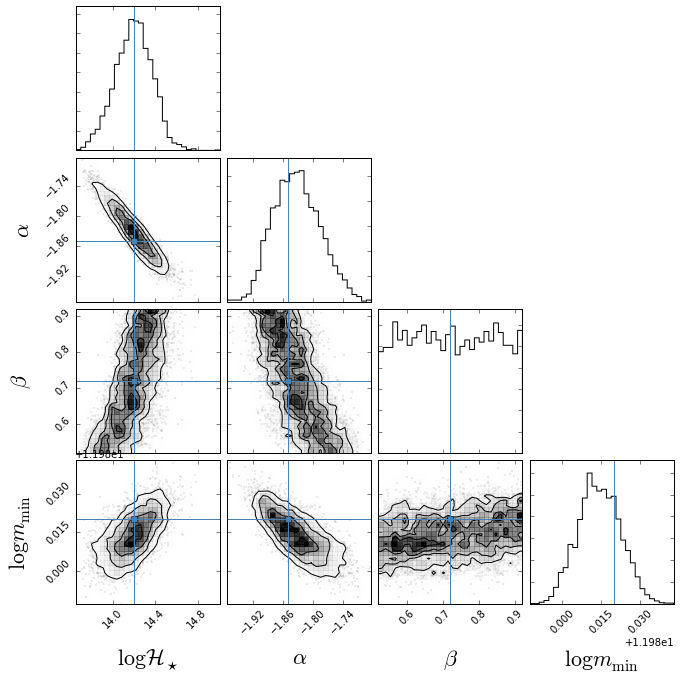

In [108]:
plot_corner(fit_err[2])

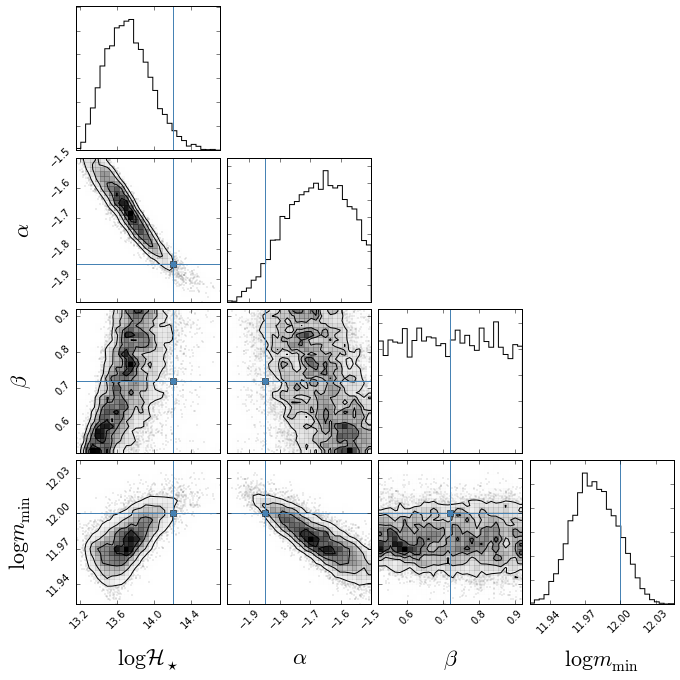

In [109]:
plot_corner(fit_err[3])

### Comparison of Methods

In [197]:
def percentile_to_errorbar(perc):
    return perc[1], np.array([[np.abs(perc[0]-perc[1]),np.abs(perc[2]-perc[1])]]).T

def get_quantiles(sf):
    samples = sf.extract(("logHs","alpha","beta"))
    logHs = np.percentile(samples['logHs'],q=(16,50,84))
    alpha = np.percentile(samples['alpha'],q=(16,50,84))
    beta = np.percentile(samples['beta'],q=(16,50,84))
    return percentile_to_errorbar(logHs), percentile_to_errorbar(alpha), percentile_to_errorbar(beta)

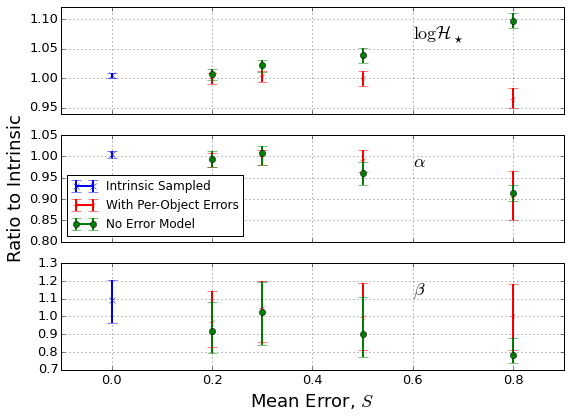

In [216]:
fig, ax = plt.subplots(3,1,figsize=(9,6.5),sharex=True,)

# Get full-error quantiles
err_q = []
for i,sf in enumerate(fit_err):
    err_q.append({k:v for k,v in zip(["hs","alpha","beta"],get_quantiles(sf))})
    
# Get no-error quantiles
no_err_q = []
for i,sf in enumerate(fit_noerr):
    no_err_q.append({k:v for k,v in zip(["hs","alpha","beta"],get_quantiles(sf))})
    
# Get intrinsic quantiles
intr_q = {k:v for k,v in zip(["hs","alpha","beta"],get_quantiles(fit_intrinsic))}


for i, par in enumerate(['hs',"alpha","beta"]):
    ax[i].grid(True)
    if i==1:
        intr_lab = "Intrinsic Sampled"
        err_lab = "With Per-Object Errors"
        noerr_lab = "No Error Model"
    else:
        intr_lab, err_lab, noerr_lab = None,None,None
        
    intr_val = [logHs,alpha,beta][i]
    
    # Plot intrinsic
    ax[i].errorbar(0.0,intr_q[par][0]/intr_val,
                   yerr=intr_q[par][1]/intr_val, 
                   color="b", marker="x", label=intr_lab,lw=2,capsize=5)

    for j,S in enumerate(sd_base):
        if j>0:
            intr_lab,err_lab,noerr_lab=None,None,None
        # Plot with full errors
        ax[i].errorbar(S, err_q[j][par][0]/intr_val,
                       yerr=err_q[j][par][1]/intr_val, 
                       color="r", marker="3",label=err_lab,lw=2,capsize=5)
        
        # Plot no errors
        ax[i].errorbar(S, no_err_q[j][par][0]/intr_val,
                       yerr=no_err_q[j][par][1]/intr_val, 
                       color="g", marker="o",label=noerr_lab,lw=2,capsize=5)
        
ax[2].set_xlabel(r"Mean Error, $S$",fontsize=18)

for i,label in enumerate([r"$\log \mathcal{H}_\star$",r"$\alpha$",r"$\beta$"]):
    ax[i].text(0.7,0.7,label,transform=ax[i].transAxes,fontdict={"fontsize":18})

    ax[i].tick_params(axis='both', which='major', labelsize=13)
    
ax[1].set_ylabel("Ratio to Intrinsic",fontsize=18)
    
ax[0].set_xlim((-0.1,0.9))
ax[1].legend(loc=0)

# Save for the paper!
plt.savefig("../../../mrpArticle/figures/heirarchical_summary.pdf")